<a href="https://colab.research.google.com/github/cocoisland/DS-Unit-2-Sprint-1-Linear-Algebra/blob/master/module4-clustering/Clustering_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering

Your assignment is to use the TMDB 5000 dataset from Kaggle to try and cluster similar movies. 

It may be helpful to use PCA to reduce the dimensions of your data first - but then again maybe not. I dunno, you're the data scientist, you tell me. 🤪 

I'll let you download the dataset and get it into your notebook in the way that works best for you:

<https://www.kaggle.com/tmdb/tmdb-movie-metadata/version/2>

There are a few weird data cleaning steps that you'll need to do that I don't want you to get stuck on or spend a lot of time on so I'll try and help you out a little bit. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA # You don't necessarily have to use this
from sklearn.cluster import KMeans # You don't necessarily have to use this

df = pd.read_csv("https://raw.githubusercontent.com/ryanleeallred/datasets/master/tmdb_5000_movies.csv")
print(df.shape)
df.head(2)

(4803, 20)


,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500


In [0]:
# There's probably some pandas function that will do this but...
str_list = [] # empty list to contain columns with strings (words)
for colname, colvalue in df.iteritems():
    if type(colvalue[1]) == str:
         str_list.append(colname)
# Get to the numeric columns by inversion            
num_list = df.columns.difference(str_list)  

In [34]:
num_list

Index(['budget', 'id', 'popularity', 'revenue', 'runtime', 'vote_average',
       'vote_count'],
      dtype='object')

In [4]:
# Filter the dataframe by only the numeric columns
df_numeric = df[num_list]
df_numeric.head()

,budget,id,popularity,revenue,runtime,vote_average,vote_count
0,237000000,19995,150.437577,2787965087,162.0,7.2,11800
1,300000000,285,139.082615,961000000,169.0,6.9,4500
2,245000000,206647,107.376788,880674609,148.0,6.3,4466
3,250000000,49026,112.312950,1084939099,165.0,7.6,9106
4,260000000,49529,43.926995,284139100,132.0,6.1,2124


In [0]:
# lazily fill NaNs with zeros
movie_num = df_numeric.fillna(value=0, axis=1)

# You take it from here!

See what you can come up with. You have all the know-how! 

In [0]:
movie_num.drop(columns='id', inplace=True)

In [0]:
# Normalize data using StandardScaler-centered by substracting mean, but
# not dividing by standard deviation.

from sklearn.preprocessing import StandardScaler
movie_norm = StandardScaler().fit_transform(movie_num)

In [0]:
# defined Elbow graph function to confirm optimal k clustering.

def plt_elbow(df):
  sum_of_squared_distanced = []
  
  K = range(1,25)
  for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(df)
    sum_of_squared_distanced.append(km.inertia_)

  plt.plot(K, sum_of_squared_distanced, marker="X")
  plt.xlabel('k', fontsize=15)
  plt.ylabel('Sum_of_squared_distanced', fontsize=15)
  plt.title('Elbow Method to find the optimal k by eyeball', fontsize=15)
  plt.show()

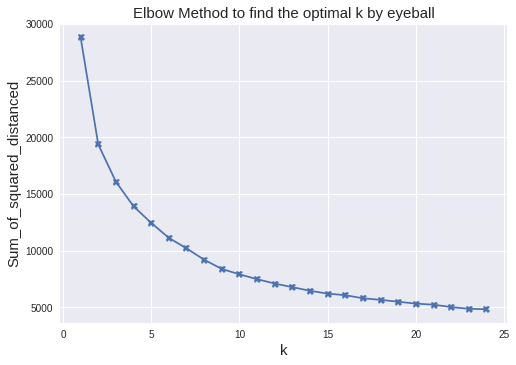

In [38]:
# To confirm KMeans accuracy by comparing Elbow graph with known 6 movie features.

plt_elbow(movie_norm)

Beyond k=6, the sum_of_squared_distanced looked too small. Diminished return beyond 6.  Make sense given there are 6 features in the normalized movie data.

In [39]:
# let PCA decide what percentage of variance ratio with the 6 principal components.
pca = PCA()
pca.fit(movie_norm)
print('\n Eigenvectors : \n', pca.components_)
print('\n Eigenvalues :\n', pca.explained_variance_)
print('\n Percentage of variance by each principal component :\n', 
      ['{:.1%}'.format(x) for x in pca.explained_variance_ratio_ ])


 Eigenvectors : 
 [[ 0.43048454  0.45951548  0.48961539  0.24890819  0.22638686  0.5005987 ]
 [-0.25417049 -0.09953298 -0.22051946  0.6115343   0.70259223 -0.09618566]
 [-0.40950268  0.33672434 -0.06933299 -0.65862139  0.48127532  0.22070149]
 [-0.52989728  0.5380056  -0.21377169  0.35596647 -0.46448361  0.203969  ]
 [ 0.50891257  0.52277672 -0.56583971 -0.05649572  0.0788603  -0.37165468]
 [-0.2064094   0.32063983  0.58392462  0.01960831  0.03902877 -0.71533878]]

 Eigenvalues :
 [3.26606119 1.1505074  0.71277677 0.4539714  0.25797091 0.1599618 ]

 Percentage of variance by each principal component :
 ['54.4%', '19.2%', '11.9%', '7.6%', '4.3%', '2.7%']


In [0]:
# Apply PCA transformation to the movie data
movie_transformed = pd.DataFrame(pca.transform(movie_norm),
             columns=['PC1','PC2','PC3','PC4','PC5','PC6'])

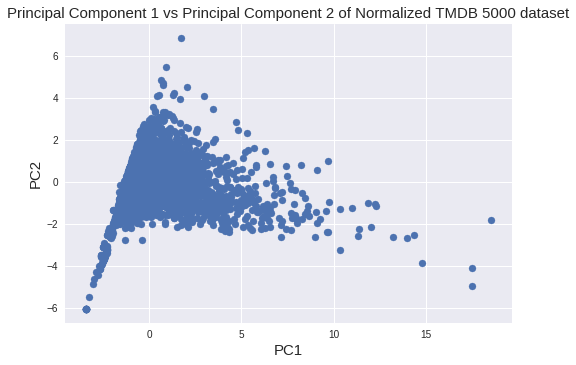

In [44]:
# 
fig, ax = plt.subplots()
ax.scatter(movie_transformed['PC1'], movie_transformed['PC2'])
plt.xlabel('PC1', fontsize=15)
plt.ylabel('PC2', fontsize=15)
plt.title('Principal Component 1 vs Principal Component 2 of Normalized TMDB 5000 dataset',
         fontsize=15)
plt.show()

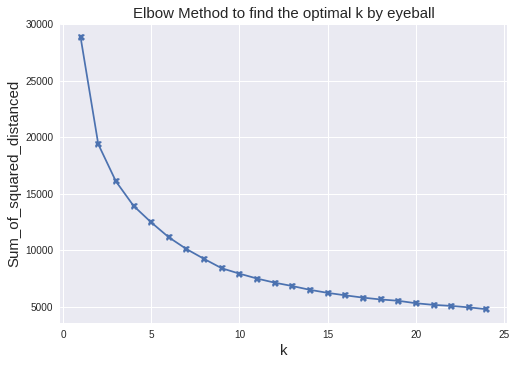

In [46]:
# Plot Elbow graph again using movie_norm_transformed data to see whether
# clear centroids can be found.

plt_elbow(movie_norm_transformed)

Choosing k=4 because beyond k=4, the sum_of_squared_distanced are getting small.

In [47]:
# Clustering based on PC1, PC2, PC3, PC4
km = KMeans(n_clusters=4)
km = km.fit(movie_norm_transformed)

# Bring in the target to PCA transformed data
movies_final = movie_norm_transformed.copy()
movies_final['title'] = df['title']
movies_final['cluster'] = km.labels_
movies_final.head()

,PC1,PC2,PC3,PC4,PC5,PC6,title,cluster
0,17.516255,-4.094039,-1.045984,-1.807989,-8.092707,3.593739,Avatar,1
1,9.584677,-1.396844,-2.650898,-1.401297,1.017042,0.835082,Pirates of the Caribbean: At World's End,1
2,7.946050,-1.761311,-2.037941,-1.217748,0.110602,0.488262,Spectre,1
3,10.998706,-1.223685,-1.262632,-0.939871,-1.808991,-1.386482,The Dark Knight Rises,1
4,4.231538,-1.214606,-2.641653,-2.262851,2.059982,-1.029592,John Carter,3


In [56]:
movies_final.cluster.value_counts()

2    2546
0    1305
3     806
1     146
Name: cluster, dtype: int64

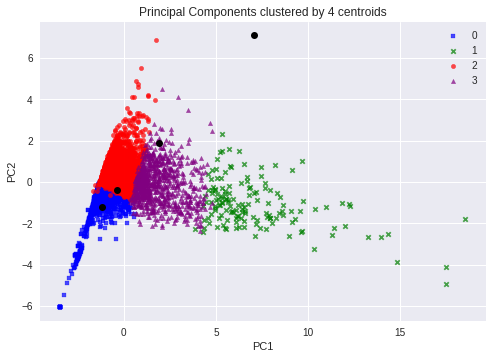

In [50]:
from mlxtend.plotting import category_scatter

centroids = movies_final.groupby('cluster').mean()

fig = category_scatter(data=movies_final, x='PC1', y='PC2',
             label_col='cluster')

for centroid in centroids.iterrows():
  plt.plot(centroid[1][0], centroid[1][0], 'ok')
  
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Principal Components clustered by 4 centroids')
plt.show()

In [53]:

# Applying KMeans o original movie data with 4 clustered

movies_num_clustered = movie_num.copy()
km = KMeans(n_clusters=4)
km = km.fit(movies_num_clustered)

movies_num_clustered['title'] = df['title']
movies_num_clustered['cluster'] = km.labels_
movies_num_clustered.head()

,budget,popularity,revenue,runtime,vote_average,vote_count,title,cluster
0,237000000,150.437577,2787965087,162.0,7.2,11800,Avatar,3
1,300000000,139.082615,961000000,169.0,6.9,4500,Pirates of the Caribbean: At World's End,3
2,245000000,107.376788,880674609,148.0,6.3,4466,Spectre,3
3,250000000,112.312950,1084939099,165.0,7.6,9106,The Dark Knight Rises,3
4,260000000,43.926995,284139100,132.0,6.1,2124,John Carter,1


In [55]:
movies_num_clustered.cluster.value_counts()

0    3522
2     912
1     285
3      84
Name: cluster, dtype: int64

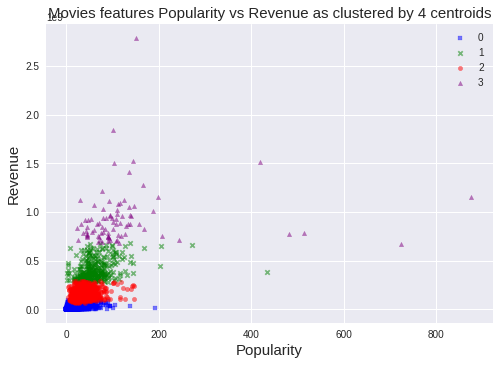

In [80]:
from mlxtend.plotting import category_scatter

#centroids = movies_num_clustered.groupby('cluster').mean()

#plt.figure(figsize=(18,10))
fig = category_scatter(data=movies_num_clustered, x='popularity', y='revenue',
             label_col='cluster' ,alpha=0.5 )

#for centroid in centroids.iterrows():
#  plt.plot(centroid[1][0], centroid[1][0], 'ok')
  
plt.xlabel('Popularity', fontsize=15)
plt.ylabel('Revenue', fontsize=15)
plt.title('Movies features Popularity vs Revenue as clustered by 4 centroids', 
          fontsize=15)
plt.show()

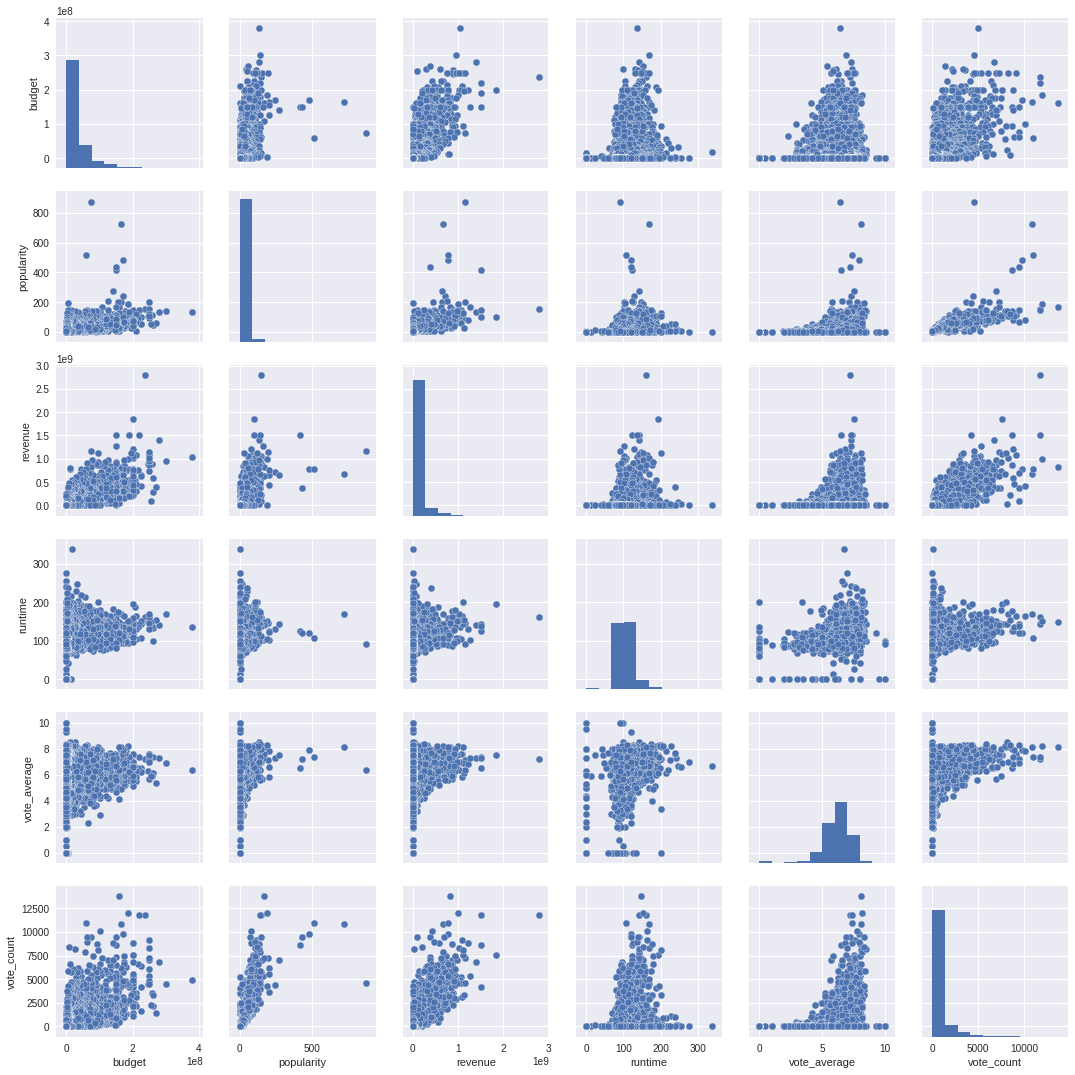

In [79]:
import seaborn as sns
sns.pairplot(movie_num)

# Stretch Goal:

If you look at the original dataset you'll notice that I threw away some potentially useful columns. See if there are any that you could clean more effectively and turn into a numeric representation (probably some kind of one-hot-encoding of categorical variables) to assist your clustering. There's a lot more work here than the hours we have today however, so don't kill yourself trying to incorporate every single column from the original dataset, just take it one column at a time.

**Side Note** Data Science is never DONE. You just reach a point where the cost isn't worth the benefit anymore. There's always more moderate to small improvements that we could make. Don't be a perfectionist, be a pragmatist.